#Model 1

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


df = pd.read_csv('DataFile_ML_All.csv')

df = df.drop(columns=['Date', 'id', 'station_code'])

# Step 1: Data Preprocessing (Assuming your data is in a DataFrame called 'data_CDEP')
selected_features = ['Secchi Depth(m)', 'DO(mg/l)', 'Temperature (deg cels)', 'Salinity(ppt)','pH', 'Turbidity(NTU)', 'Nitrate+Nitrite','Phosphate', 'N/P', 'Julian Year']
X = df[selected_features]  # Independent variables
y = df['Chlorophyll-a (ug/l)']  # Log-transform the target variable        # Target variable

# Perform an 70-30 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## 2. XGBoost Regression Model

In [11]:
#Bayesian Optimization

In [2]:
from skopt import gp_minimize
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

def objective_function(params):
    # Convert the parameter values to the appropriate type and range
    n_estimators, max_depth, learning_rate = params

    # Create an XGBoost model with the specified hyperparameters
    model = XGBRegressor(
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        learning_rate=learning_rate,
        random_state=42,
    )

    # Calculate the negative mean absolute error (we want to minimize it)
    mae_scores = -cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    
    # Calculate the average MAE score
    avg_mae = mae_scores.mean()

    return avg_mae


from skopt.space import Integer, Real

space = [
    Integer(1, 200, name='n_estimators'),
    Integer(1, 20, name='max_depth'),
    Real(0.001, 0.1, name='learning_rate')
]


result = gp_minimize(objective_function, space, n_calls=10, random_state=42)

# The result variable will contain the optimal hyperparameters that minimize MAE
optimal_hyperparameters = result.x
optimal_mae = result.fun

# Print the best hyperparameters and corresponding MAE
print("Best Hyperparameters:")
for param, value in zip(space, optimal_hyperparameters):
    print(f"{param.name}: {value}")
print("Optimal MAE:", optimal_mae)

Best Hyperparameters:
n_estimators: 160
max_depth: 4
learning_rate: 0.07818940902700418
Optimal MAE: 2.4309346308910937


Mean MAE: 2.4221
Standard Deviation MAE: 0.4379


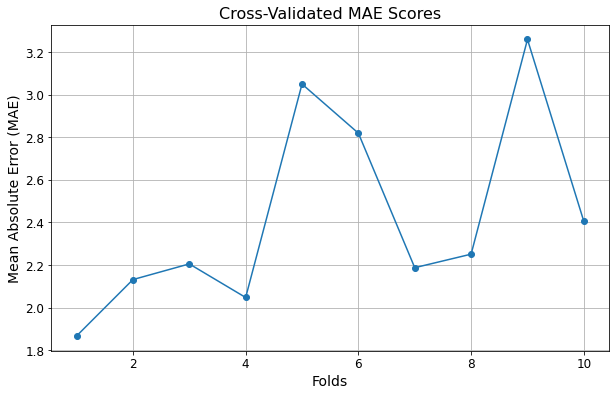

In [3]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# Initialize and configure the XGBoost regression model
xgb_model = XGBRegressor(
    n_estimators=160,
    max_depth=4,
    learning_rate=0.07818940902700418,
    random_state=42
)

# Perform cross-validation
cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')
mae_scores = -cv_scores  # Convert negative MAE scores to positive

# Calculate the mean and standard deviation of the MAE scores
mean_mae = np.mean(mae_scores)
std_mae = np.std(mae_scores)

print("Mean MAE: {:.4f}".format(mean_mae))
print("Standard Deviation MAE: {:.4f}".format(std_mae))

# Plot the cross-validation scores with larger fontsizes
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), mae_scores, marker='o', linestyle='-')
plt.title("Cross-Validated MAE Scores", fontsize=16)  # Set title fontsize
plt.xlabel("Folds", fontsize=14)  # Set xlabel fontsize
plt.ylabel("Mean Absolute Error (MAE)", fontsize=14)  # Set ylabel fontsize
plt.xticks(fontsize=12)  # Set tick labels fontsize for x-axis
plt.yticks(fontsize=12)  # Set tick labels fontsize for y-axis
plt.grid(True)

# Save the plot as an image
plt.savefig('CV_XGBoostBayesian_01.jpeg')

# Show the plot
plt.show()

Hyperparameter n_estimators: 94
Hyperparameter max_depth: 26
Hyperparameter min_samples_split: 7
Hyperparameter min_samples_leaf: 5
Optimal MAE: 2.3367156873975334

In [4]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

# Initialize lists to store the performance metrics over iterations
train_r2_values = []
test_r2_values = []
train_mse_values = []
test_mse_values = []
train_rmse_values = []
test_rmse_values = []
train_mae_values = []
test_mae_values = []
train_pbias_values = []
test_pbias_values = []

# Number of iterations
num_iterations = 100

for iteration in range(num_iterations):
    # Create an XGBoost model
    xgb_model_Bayesian_01 = XGBRegressor(random_state=42, n_estimators=160, max_depth=4, learning_rate=0.07818940902700418)


    # Fit the model on the full training data
    xgb_model_Bayesian_01.fit(X_train, y_train)

    # Make predictions on both training and test data
    y_train_pred = xgb_model_Bayesian_01.predict(X_train)
    y_test_pred = xgb_model_Bayesian_01.predict(X_test)

    # Calculate performance metrics for the current iteration
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)

    # Calculate PBIAS (Percent Bias)
    pbias_train = ((y_train - y_train_pred) / y_train).mean() * 100
    pbias_test = ((y_test - y_test_pred) / y_test).mean() * 100

    # Append the performance metrics for the current iteration to the lists
    train_r2_values.append(r2_train)
    test_r2_values.append(r2_test)
    train_mse_values.append(mse_train)
    test_mse_values.append(mse_test)
    train_rmse_values.append(rmse_train)
    test_rmse_values.append(rmse_test)
    train_mae_values.append(mae_train)
    test_mae_values.append(mae_test)
    train_pbias_values.append(pbias_train)
    test_pbias_values.append(pbias_test)

# Calculate the average of the performance metrics over all iterations
average_train_r2 = sum(train_r2_values) / num_iterations
average_test_r2 = sum(test_r2_values) / num_iterations
average_train_mse = sum(train_mse_values) / num_iterations
average_test_mse = sum(test_mse_values) / num_iterations
average_train_rmse = sum(train_rmse_values) / num_iterations
average_test_rmse = sum(test_rmse_values) / num_iterations
average_train_mae = sum(train_mae_values) / num_iterations
average_test_mae = sum(test_mae_values) / num_iterations
average_train_pbias = sum(train_pbias_values) / num_iterations
average_test_pbias = sum(test_pbias_values) / num_iterations

# Print the average performance metrics
print("Average Train R2:", average_train_r2)
print("Average Test R2:", average_test_r2)
print("Average Train MSE:", average_train_mse)
print("Average Test MSE:", average_test_mse)
print("Average Train RMSE:", average_train_rmse)
print("Average Test RMSE:", average_test_rmse)
print("Average Train MAE:", average_train_mae)
print("Average Test MAE:", average_test_mae)
print("Average Train PBIAS:", average_train_pbias)
print("Average Test PBIAS:", average_test_pbias)

Average Train R2: 0.9421777361092726
Average Test R2: 0.6424705757154991
Average Train MSE: 1.5567764620046654
Average Test MSE: 9.262189846287017
Average Train RMSE: 1.2477084843843362
Average Test RMSE: 3.043384603740884
Average Train MAE: 0.911678617417811
Average Test MAE: 2.2566511206436526
Average Train PBIAS: -10.31812735438305
Average Test PBIAS: -35.14673486128924


In [6]:
#Saving the trained model

import pickle

# Save the Random Forest model to a file using pickle
with open('xgb_model_Bayesian_01.pkl', 'wb') as file:
    pickle.dump(xgb_model_Bayesian_01, file)
    
import joblib

# Save the Random Forest model to a file using joblib
joblib.dump(xgb_model_Bayesian_01, 'xgb_model_Bayesian_01.joblib')

['xgb_model_Bayesian_01.joblib']

In [ ]:
#Grid Search Optimization

In [12]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV

# Define a grid of hyperparameters
param_grid = {
    'n_estimators': [50, 60, 70, 80, 90, 100, 140, 130, 150, 180],
    'max_depth': [2, 3 , 5, 7],
    'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15]
}

# Create an XGBoost model
model = XGBRegressor(random_state=42)

# Create a GridSearchCV object
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_absolute_error')

# Fit the model with the data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and model
best_hyperparameters = grid_search.best_params_
best_model = grid_search.best_estimator_

# Calculate the mean absolute error on the test set
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)

# Print the best hyperparameters and MAE
print("Best Hyperparameters:")
for param, value in best_hyperparameters.items():
    print(f"{param}: {value}")
print(f"Mean Absolute Error: {mae}")

Best Hyperparameters:
learning_rate: 0.1
max_depth: 5
n_estimators: 80
Mean Absolute Error: 2.336928571530621


In [8]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

# Initialize lists to store the performance metrics over iterations
train_r2_values = []
test_r2_values = []
train_mse_values = []
test_mse_values = []
train_rmse_values = []
test_rmse_values = []
train_mae_values = []
test_mae_values = []
train_pbias_values = []
test_pbias_values = []

# Number of iterations
num_iterations = 100

for iteration in range(num_iterations):
    # Create an XGBoost model
    xgb_model_Grid_01 = XGBRegressor(random_state=42, n_estimators=80, max_depth=5, learning_rate=0.1)


    # Fit the model on the full training data
    xgb_model_Grid_01.fit(X_train, y_train)

    # Make predictions on both training and test data
    y_train_pred = xgb_model_Grid_01.predict(X_train)
    y_test_pred = xgb_model_Grid_01.predict(X_test)

    # Calculate performance metrics for the current iteration
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)

    # Calculate PBIAS (Percent Bias)
    pbias_train = ((y_train - y_train_pred) / y_train).mean() * 100
    pbias_test = ((y_test - y_test_pred) / y_test).mean() * 100

    # Append the performance metrics for the current iteration to the lists
    train_r2_values.append(r2_train)
    test_r2_values.append(r2_test)
    train_mse_values.append(mse_train)
    test_mse_values.append(mse_test)
    train_rmse_values.append(rmse_train)
    test_rmse_values.append(rmse_test)
    train_mae_values.append(mae_train)
    test_mae_values.append(mae_test)
    train_pbias_values.append(pbias_train)
    test_pbias_values.append(pbias_test)

# Calculate the average of the performance metrics over all iterations
average_train_r2 = sum(train_r2_values) / num_iterations
average_test_r2 = sum(test_r2_values) / num_iterations
average_train_mse = sum(train_mse_values) / num_iterations
average_test_mse = sum(test_mse_values) / num_iterations
average_train_rmse = sum(train_rmse_values) / num_iterations
average_test_rmse = sum(test_rmse_values) / num_iterations
average_train_mae = sum(train_mae_values) / num_iterations
average_test_mae = sum(test_mae_values) / num_iterations
average_train_pbias = sum(train_pbias_values) / num_iterations
average_test_pbias = sum(test_pbias_values) / num_iterations

# Print the average performance metrics
print("Average Train R2:", average_train_r2)
print("Average Test R2:", average_test_r2)
print("Average Train MSE:", average_train_mse)
print("Average Test MSE:", average_test_mse)
print("Average Train RMSE:", average_train_rmse)
print("Average Test RMSE:", average_test_rmse)
print("Average Train MAE:", average_train_mae)
print("Average Test MAE:", average_test_mae)
print("Average Train PBIAS:", average_train_pbias)
print("Average Test PBIAS:", average_test_pbias)

Average Train R2: 0.9568923338319167
Average Test R2: 0.5976946190710565
Average Train MSE: 1.1606083108272827
Average Test MSE: 10.42215985944017
Average Train RMSE: 1.0773153256253634
Average Test RMSE: 3.2283370114410554
Average Train MAE: 0.7705809364770745
Average Test MAE: 2.336928571530621
Average Train PBIAS: -9.58408527270353
Average Test PBIAS: -33.76199373017926


In [10]:
#Saving the trained model

import pickle

# Save the Random Forest model to a file using pickle
with open('xgb_model_Grid_01.pkl', 'wb') as file:
    pickle.dump(xgb_model_Grid_01, file)
import joblib

# Save the Random Forest model to a file using joblib
joblib.dump(xgb_model_Grid_01, 'xgb_model_Grid_01.joblib')

['xgb_model_Grid_01.joblib']

In [ ]:
#randomized search optimization

In [14]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define the hyperparameter distributions
param_dist = {
    'n_estimators': [50, 60, 70, 80, 90, 100, 140, 130, 150, 180, 190],
    'max_depth': [2, 3 , 5, 7],
    'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15]
}

# Create an XGBoost model
model = XGBRegressor(random_state=42)

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=5, scoring='neg_mean_absolute_error', random_state=42)

# Fit the model with the data
random_search.fit(X_train, y_train)

# Get the best hyperparameters and model
best_hyperparameters = random_search.best_params_
best_model = random_search.best_estimator_

# Calculate the mean absolute error on the test set
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)

# Print the best hyperparameters and MAE
print("Best Hyperparameters:")
for param, value in best_hyperparameters.items():
    print(f"{param}: {value}")
print(f"Mean Absolute Error: {mae}")

Best Hyperparameters:
n_estimators: 100
max_depth: 3
learning_rate: 0.11
Mean Absolute Error: 2.333142458531446


In [15]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
from xgboost import XGBRegressor


# Initialize lists to store the performance metrics over iterations
train_r2_values = []
test_r2_values = []
train_mse_values = []
test_mse_values = []
train_rmse_values = []
test_rmse_values = []
train_mae_values = []
test_mae_values = []
train_pbias_values = []
test_pbias_values = []

# Number of iterations
num_iterations = 100

for iteration in range(num_iterations):
    # Create an XGBoost model
    xgb_model_Random_01 = XGBRegressor(random_state=42, n_estimators=100, max_depth=3, learning_rate=0.11)


    # Fit the model on the full training data
    xgb_model_Random_01.fit(X_train, y_train)

    # Make predictions on both training and test data
    y_train_pred = xgb_model_Random_01.predict(X_train)
    y_test_pred = xgb_model_Random_01.predict(X_test)

    # Calculate performance metrics for the current iteration
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)

    # Calculate PBIAS (Percent Bias)
    pbias_train = ((y_train - y_train_pred) / y_train).mean() * 100
    pbias_test = ((y_test - y_test_pred) / y_test).mean() * 100

    # Append the performance metrics for the current iteration to the lists
    train_r2_values.append(r2_train)
    test_r2_values.append(r2_test)
    train_mse_values.append(mse_train)
    test_mse_values.append(mse_test)
    train_rmse_values.append(rmse_train)
    test_rmse_values.append(rmse_test)
    train_mae_values.append(mae_train)
    test_mae_values.append(mae_test)
    train_pbias_values.append(pbias_train)
    test_pbias_values.append(pbias_test)

# Calculate the average of the performance metrics over all iterations
average_train_r2 = sum(train_r2_values) / num_iterations
average_test_r2 = sum(test_r2_values) / num_iterations
average_train_mse = sum(train_mse_values) / num_iterations
average_test_mse = sum(test_mse_values) / num_iterations
average_train_rmse = sum(train_rmse_values) / num_iterations
average_test_rmse = sum(test_rmse_values) / num_iterations
average_train_mae = sum(train_mae_values) / num_iterations
average_test_mae = sum(test_mae_values) / num_iterations
average_train_pbias = sum(train_pbias_values) / num_iterations
average_test_pbias = sum(test_pbias_values) / num_iterations

# Print the average performance metrics
print("Average Train R2:", average_train_r2)
print("Average Test R2:", average_test_r2)
print("Average Train MSE:", average_train_mse)
print("Average Test MSE:", average_test_mse)
print("Average Train RMSE:", average_train_rmse)
print("Average Test RMSE:", average_test_rmse)
print("Average Train MAE:", average_train_mae)
print("Average Test MAE:", average_test_mae)
print("Average Train PBIAS:", average_train_pbias)
print("Average Test PBIAS:", average_test_pbias)

Average Train R2: 0.8392626030121549
Average Test R2: 0.5943107733919395
Average Train MSE: 4.327609805584019
Average Test MSE: 10.509822073964862
Average Train RMSE: 2.0802907983222028
Average Test RMSE: 3.2418855738543413
Average Train MAE: 1.462662210840509
Average Test MAE: 2.3331424585314493
Average Train PBIAS: -20.62684767048955
Average Test PBIAS: -39.45243107281837


In [16]:
#Saving the trained model

import pickle

# Save the Random Forest model to a file using pickle
with open('xgb_model_Random_01.pkl', 'wb') as file:
    pickle.dump(xgb_model_Random_01, file)
import joblib

# Save the Random Forest model to a file using joblib
joblib.dump(xgb_model_Random_01, 'xgb_model_Random_01.joblib')

['xgb_model_Random_01.joblib']

In [ ]:
#Normal Code:

In [ ]:
#No iterations

In [ ]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Select the features and target variable
#selected_features = ['Secchi Depth(m)', 'DO(mg/l)', 'Temperature (deg cels)', 'Salinity(ppt)','pH', 'Turbidity(NTU)','Nitrate+Nitrite']

selected_features = ['Secchi Depth(m)', 'DO(mg/l)', 'Temperature (deg cels)', 'Salinity(ppt)','pH', 'Turbidity(NTU)', 'Nitrate+Nitrite', 'N/P' ,'ATemp_max_1dlag',
    'ATemp_max_2dlag', 'ATemp_max_3dlag', 'ATemp_max_4dlag', 'ATemp_max_5dlag', 'ATemp_max_6dlag', 'ATemp_max_7dlag']

X = df[selected_features]  # Independent variables
y = np.log1p(df['Chlorophyll-a (ug/l)'])  # Log-transform the target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the number of iterations (J) for your custom random forest
J = 1000  # You can adjust the number of iterations as needed

# Define the maximum depth and other hyperparameters for your custom decision trees
max_depth = 20
min_samples_split = 4
min_samples_leaf = 2
ccp_alpha = 0.001  # Pruning

# Initialize lists to store individual custom decision tree models
custom_trees = []

# Step 2: Training J Custom Decision Trees
for j in range(J):
    # Create a bootstrap sample Dj of size N from the training data
    bootstrap_indices = np.random.choice(len(X_train), size=len(X_train), replace=True)
    X_bootstrap = X_train.iloc[bootstrap_indices]
    y_bootstrap = y_train.iloc[bootstrap_indices]

    # Initialize and train a custom decision tree
    custom_tree = DecisionTreeRegressor(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        ccp_alpha=ccp_alpha,
        random_state=4200
    )
    custom_tree.fit(X_bootstrap, y_bootstrap)

    # Append the trained custom decision tree to the list
    custom_trees.append(custom_tree)

# Step 3: Predictions and Combining Decision Trees
def combine_custom_trees(predictions):
    return np.mean(predictions, axis=0)

# Predictions for your custom random forest on training data
predictions_train = [tree.predict(X_train) for tree in custom_trees]
combined_predictions_train = combine_custom_trees(predictions_train)

# Calculate Mean Squared Error (MSE) and R-squared (R2) for training data
mse_train = mean_squared_error(y_train, combined_predictions_train)
r2_train = r2_score(y_train, combined_predictions_train)

# Print the evaluation metrics for training data
print("Mean Squared Error (Train): {:.4f}".format(mse_train))
print("R-squared (Train): {:.4f}".format(r2_train))

# Predictions for your custom random forest on test data
predictions_test = [tree.predict(X_test) for tree in custom_trees]
combined_predictions_test = combine_custom_trees(predictions_test)

# Calculate Mean Squared Error (MSE) and R-squared (R2) for test data
mse_test = mean_squared_error(y_test, combined_predictions_test)
r2_test = r2_score(y_test, combined_predictions_test)

# Print the evaluation metrics for test data
print("\nMean Squared Error (Test): {:.4f}".format(mse_test))
print("R-squared (Test): {:.4f}".format(r2_test))

# Plot the results for training data
plt.figure(figsize=(8, 6))
plt.scatter(y_train, combined_predictions_train, c='blue', label='Actual vs. Predicted (Training)')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 'k--', lw=2)
plt.xlabel('Actual Chlorophyll-a (Train)', fontsize=14)
plt.ylabel('Predicted Chlorophyll-a (Train)', fontsize=14)
plt.title('Decision Tree Regression - Training Data', fontsize=14)
plt.legend(fontsize=14)
plt.savefig('Train_DecTree.jpeg')
plt.show()


# Plot the results for test data
plt.figure(figsize=(8, 6))
plt.scatter(y_test, combined_predictions_test, c='green', label='Actual vs. Predicted (Test)')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2)
plt.xlabel('Actual Chlorophyll-a (Test)', fontsize=14)
plt.ylabel('Predicted Chlorophyll-a (Test)', fontsize=14)
plt.title('Decision Tree Regression - Test Data', fontsize=14)
plt.legend(fontsize=10)
plt.savefig('Test_DecTree.jpeg')
plt.show()